In [1]:
#Resolve the required imports
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # To visualize
from tabulate import tabulate #To create pretty tables
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from pprint import pprint
from scipy.interpolate import make_interp_spline, BSpline # To create smooth curves

In [2]:
#read in the data
base_directory = "/home/jeanpierre/LibraMetrics/containersMetricsFiles/Experiment4/250_tick_interval/2020_09_15__09_31_40/"
#base_directory = "/home/jeanpierre/LibraMetrics/containersMetricsFiles/Experiment1/5_nodes/2020_09_10__01_32_36/"
#base_directory = "/home/jeanpierre/libra2/libra2/experiments_logs/Experiment1/2_nodes/2020_09_10__01_22_01/"

files = ["merged/jp_consensus_process_proposal.csv", "merged/jp_mempool_process_incoming_transactions.csv", "merged/jp_consensus_process_new_round.csv"]

data_frames = []
for file_name in files:
    data_frame = pd.read_csv(base_directory + file_name, names=["txns", "duration"])
    data_frames.append(data_frame)

In [3]:
#convert duration from microseconds to milliseconds
i = 0
while i < len(data_frames):
    data_frames[i]["duration"] *= .001
    i += 1

In [4]:
coefficients_models = [] 
print("#entries(0):", len(data_frames[0]))
print("#entries(1):", len(data_frames[1]))
print("#entries(2):", len(data_frames[2]))

#entries(0): 624822
#entries(1): 2376373
#entries(2): 104152


Plot before data cleaning:



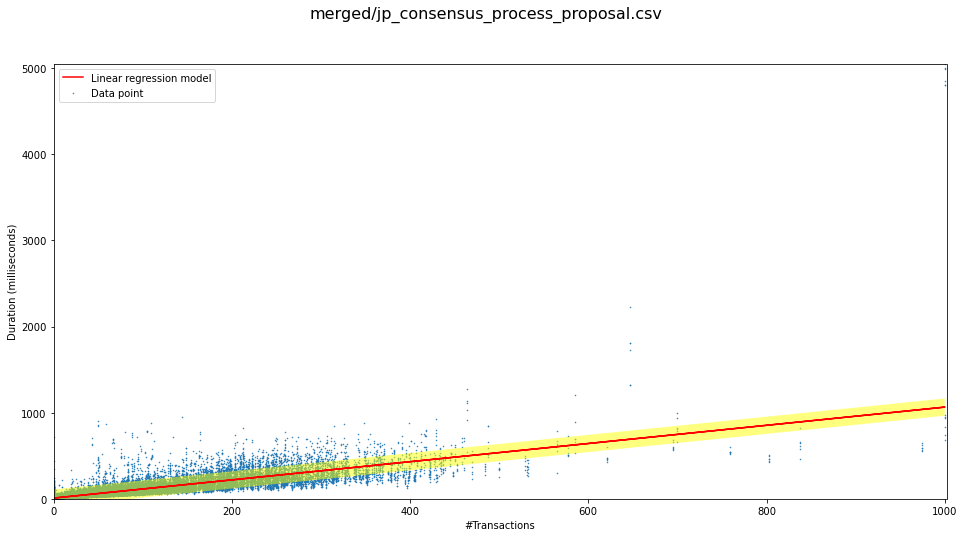

In [104]:
#Perform linear regression with R-sqaured score with pyplot before data cleanup
model_nr = 0

X = data_frames[model_nr].iloc[:, 0].values.reshape(-1, 1)
Y = data_frames[model_nr].iloc[:, 1].values.reshape(-1, 1)
print("Plot before data cleaning:")

print()
plot_regression(data_frames[model_nr], files[model_nr])

In [7]:
#Data cleanup
data_cleaned = pd.DataFrame(columns = ["txns", "duration"])

data = data_frames[model_nr][data_frames[model_nr]['txns'] > 0].reset_index(drop=True)

data = data.groupby('txns').filter(lambda x: len(x) > 1)

#data = data[data['txns'].between(data['txns'].quantile(0), data['txns'].quantile(.95))]

i = 1
while i <= max(data['txns']):
    temp_data = data[data['txns'] == i]
    if len(temp_data) < 1:
        i+=1
        continue;
        
    temp_data = temp_data[temp_data['duration'] <= 2*temp_data['duration'].std() + temp_data['duration'].mean()]
    data_cleaned = data_cleaned.append(temp_data)
    i+=1
    
#data_cleaned = data_frames[model_nr]

In [118]:
def plot_regression(data, name):
    X = data['txns'].values.reshape(-1, 1)
    Y = data['duration'].values.reshape(-1, 1)
    
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)

    fig = plt.figure(figsize=(16,8))
    fig.suptitle(name, fontsize=16)
    ax = fig.add_subplot()
    ax.set_xlabel('#Transactions')
    ax.set_ylabel('Duration (milliseconds)')

    ax.scatter(X, Y, marker='.', s=1, label='Data point')
    ax.plot(X, Y_pred, color='red', label='Linear regression model')
    
    Y_pred = linear_regressor.predict(np.arange(min(X), max(X)+1).reshape(-1,1))
    std = data.groupby('txns')['duration'].std().reset_index()
    
    print(std)
    i = 0
    while i < 1000:
        if std.iloc[i,0] != i:
            print("test")
        i+=1
    
    ax.fill_between(np.arange(min(X), max(X)+1), Y_pred.flatten()-std['duration'], Y_pred.flatten()+std['duration'], facecolor='yellow', alpha=0.5)

    plt.legend(loc='upper left')
    ax.set_xlim(0, X.max()+2)
    ax.set_ylim(0, Y.max());
    #plt.savefig('pic.png')

Plot after data cleaning:
     txns     duration
0       0     3.607096
1       1     5.811566
2       2     6.235227
3       3     6.775192
4       4     6.758517
..    ...          ...
425   759    27.884962
426   803    30.387405
427   838   116.955351
428   975    33.362955
429  1000  2123.481574

[430 rows x 2 columns]
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test

IndexError: single positional indexer is out-of-bounds

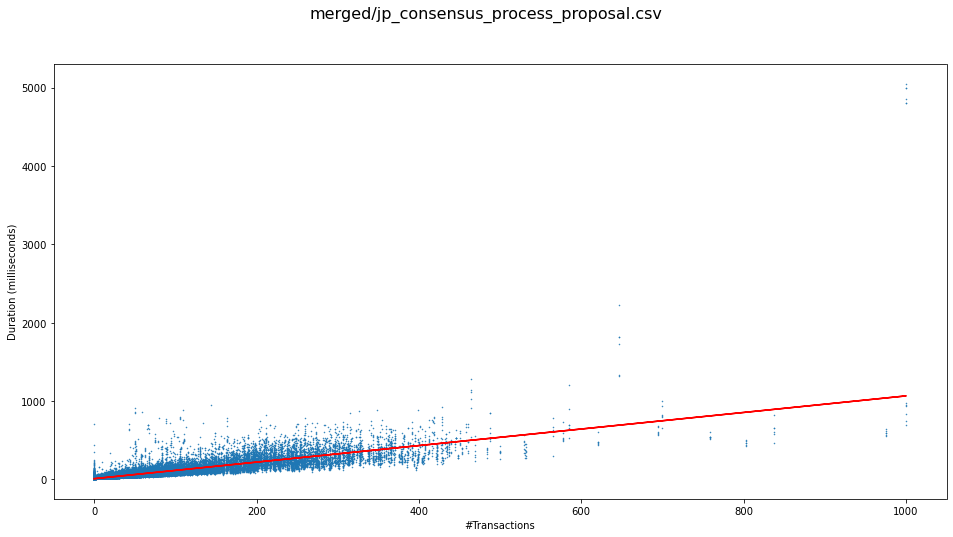

In [119]:
#Perform linear regression with R-sqaured score with pyplot after data cleanup
X = data_cleaned.iloc[:, 0].values.reshape(-1, 1)
Y = data_cleaned.iloc[:, 1].values.reshape(-1, 1)
print("Plot after data cleaning:")

plot_regression(data_frames[model_nr], files[model_nr])

/home/jeanpierre/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Data points: 59
2.2250309688740293 69.96240591738433 41.44412069163794
alpha: KstestResult(statistic=0.08753706733193345, pvalue=0.7234034801101001)
Other: KstestResult(statistic=0.0873945613886647, pvalue=0.7252195209669644)


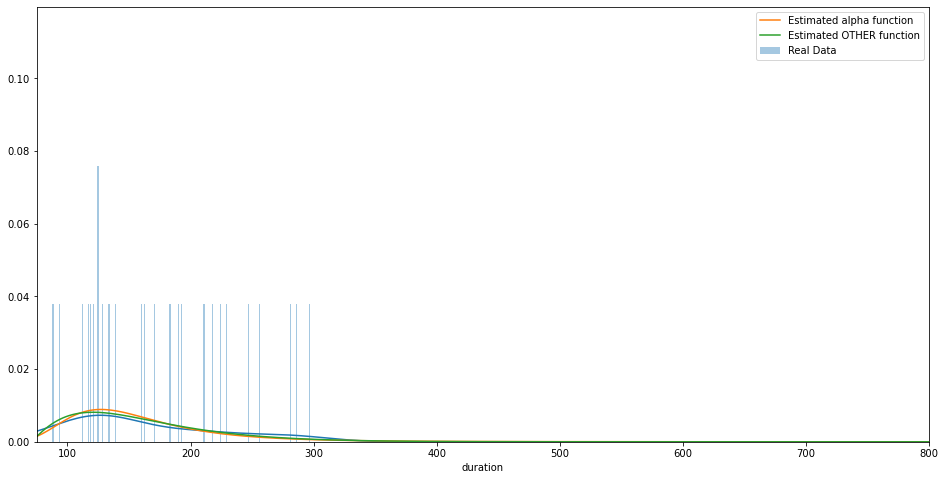

In [9]:
fig, ax = plt.subplots(figsize=(16,8))

data = data_cleaned[data_cleaned['txns'] == 150]['duration']

sns.distplot(data, ax=ax, label="Real Data", bins=500)

#Fitting the gamma distribution
x_min = min(data)
x_max = 800
X = np.linspace(x_min, x_max, 300)

fit_a_alpha, fit_loc_alpha, fit_scale_alpha = stats.alpha.fit(data)
fit_a, fit_loc, fit_scale = stats.gamma.fit(data)

alpha_fit = stats.alpha(fit_a_alpha, loc=fit_loc_alpha, scale=fit_scale_alpha)
gamma_fit = stats.gamma(fit_a, loc=fit_loc, scale=fit_scale)

#gamma_manual = stats.gamma(a=1.4, loc=0, scale=1.1)
ax.plot(X, alpha_fit.pdf(X), label="Estimated alpha function")
ax.plot(X, gamma_fit.pdf(X), label="Estimated OTHER function")
#ax.plot(X, gamma_manual.pdf(X), label="Manual gamma function")
ax.set_xlim(x_min, x_max)
ax.legend()
print("Data points:", len(data))
print(fit_a, fit_loc, fit_scale)

p_alpha_fit = stats.kstest(data, alpha_fit.cdf)
p_fit = stats.kstest(data, gamma_fit.cdf)
#p_manual = stats.kstest(data, gamma_manual.cdf)
print("alpha:", p_alpha_fit)
print("Other:", p_fit)
#print(p_manual)

[0.23279581042618458, 0.1495932381690822, 0.33270540466870435, 0.061071888017353304, 0.21835034565570466, 0.3504497884619763, 0.18783383098935624, 0.3140808346687085, 0.9682778651460748, 0.1886509994769634, 0.37220033190220514, 0.15273339564574429, 0.09997220763113146, 0.06446714086678274, 0.07628284585339651, 0.10252501708916795, 0.12098266422101844, 0.4453149109506922, 0.6539314791841357, 0.5656051720112197, 0.14908004805774333, 0.3446113037149975, 0.6912352873244966, 0.6017068051494932, 0.1642694748701241, 0.1273235774664575, 0.4127077420364088, 0.11241305864294016, 0.3859611944338648, 0.3002871831264209, 0.6995345557498833, 0.4310107802244594, 0.06518494482637704, 0.5439282368884286, 0.22192374580988528, 0.1385536907111763, 0.6661971873589929, 0.24867757324010342, 0.19003584024312803, 0.1152711377061304, 0.18247331795345034, 0.11655678041728745, 0.8448182230849361, 0.6686080863833606, 0.18916614086908778, 0.5055279638880285, 0.3296269714059732, 0.6545532235729405, 0.420771514737618

Text(0.3, 0.9, '$Avg-P-value(model)=0.000$')

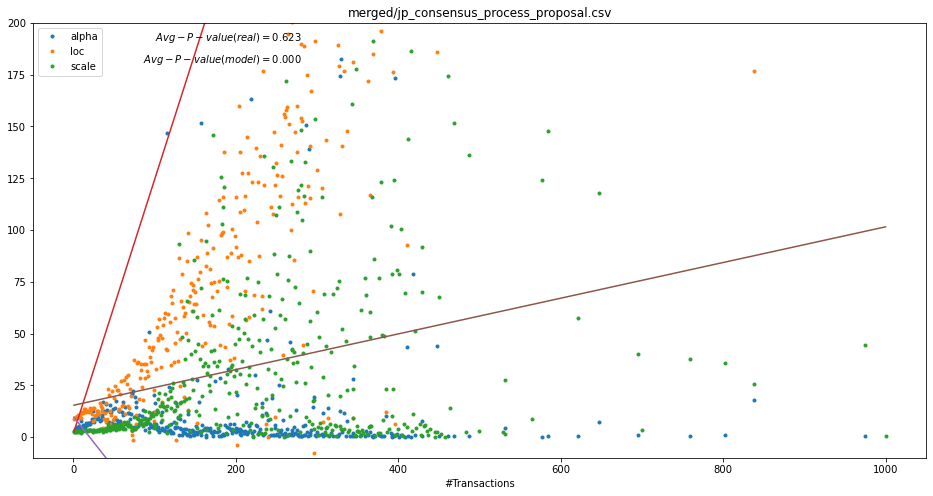

In [10]:
#Fit and print the Gamma distribution parameters
temp_fit_alpha = []
temp_fit_loc = []
temp_fit_scale = []
temp_p_fit_real = []
X = []

i = 1
max_txns = max(data_cleaned['txns'])
while i <= max_txns:
    data = data_cleaned[data_cleaned['txns'] == i]['duration']
    if len(data) < 1:
        i += 1
        continue
    fit_alpha, fit_loc, fit_scale = stats.gamma.fit(data)
    temp_fit_alpha.append(fit_alpha)
    temp_fit_loc.append(fit_loc)
    temp_fit_scale.append(fit_scale)
    
    p_fit = stats.kstest(data, stats.gamma(fit_alpha, loc=fit_loc, scale=fit_scale).cdf)
    temp_p_fit_real.append(p_fit[1])
    X.append(i)
    i += 1

X = np.array(X).reshape(-1,1)

fig, ax = plt.subplots(figsize=(16,8))
ax.set_title(files[model_nr])
ax.set_xlabel('#Transactions')
ax.set_ylim(-10, 200)

ax.plot(X, temp_fit_alpha, label='alpha', marker='.', linestyle='None')
ax.plot(X, temp_fit_loc, label='loc', marker='.', linestyle='None')
ax.plot(X, temp_fit_scale, label='scale', marker='.', linestyle='None')
ax.legend(loc='upper left')

#Model the three gamma parameters into a polynomial fit
weights = np.ones_like(temp_fit_alpha)
i = 0
while i < len(temp_fit_alpha):
    weights[i] = len(data_cleaned[data_cleaned['txns'] == i])
    i+=1

weights[1] *= 9999
weights[len(weights)-1] = 10

coefficients_alpha = np.polyfit(X.flatten(), temp_fit_alpha, 1, w=weights)
poly_alpha = np.poly1d(coefficients_alpha)
new_y = poly_alpha(X.flatten())
ax.plot(X.flatten(), new_y)

coefficients_loc = np.polyfit(X.flatten(), temp_fit_loc, 1, w=weights)
poly_loc = np.poly1d(coefficients_loc)
new_y = poly_loc(X.flatten())
ax.plot(X.flatten(), new_y)

coefficients_scale = np.polyfit(X.flatten(), temp_fit_scale, 1)
poly_scale = np.poly1d(coefficients_scale)
new_y = poly_scale(X.flatten())
ax.plot(X.flatten(), new_y)

coefficients_models.append([coefficients_alpha, coefficients_loc, coefficients_scale])

#Calculate the p-values for the linear fit models
temp_p_fit_model = []
i = 1
while i < len(X):
    data = data_cleaned[data_cleaned['txns'] == i]['duration']
    if len(data) <= 1:
        i += 1
        continue
    
    a_pred = poly_alpha(i)
    loc_pred = poly_loc(i)
    scale_pred = poly_scale(i)
    
    p_fit = stats.kstest(data, stats.gamma(a_pred, loc=loc_pred, scale=scale_pred).cdf)
    temp_p_fit_model.append(p_fit[1])
    i += 1

print(temp_p_fit_real[0:200])
#print(temp_p_fit_model)
ax.text(0.3, 0.95, "$Avg-P-value(real)={:.3f}$".format(stats.describe(temp_p_fit_real)[2]), verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
ax.text(0.3, 0.9, "$Avg-P-value(model)={:.3f}$".format(stats.describe(temp_p_fit_model)[2]), verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)


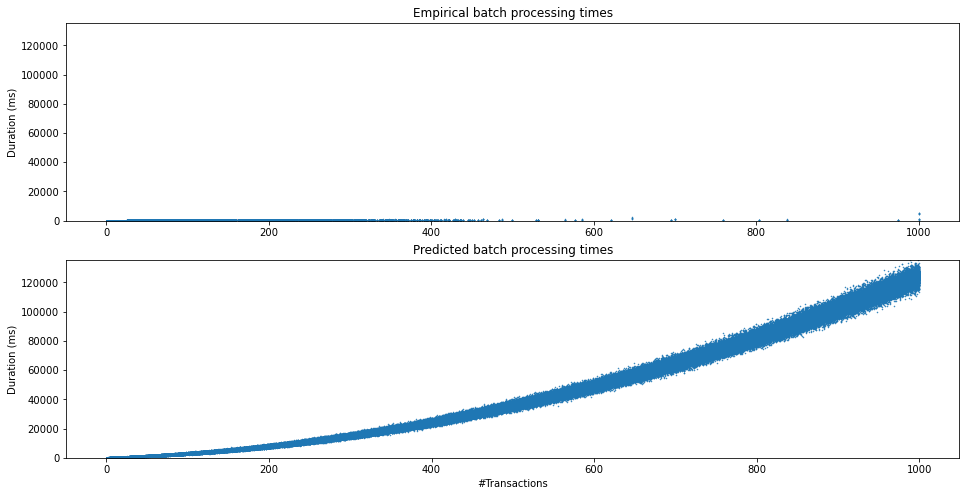

In [11]:
#Create and plot both the empirical/estimated batch processing times
X_data = []
Y_data = []

i = 1
while i < max(data_cleaned['txns']):
    nr_txns = [[i]]
    a_pred = poly_alpha(i)
    loc_pred = poly_loc(i)
    scale_pred = poly_scale(i)

    rvs = stats.gamma.rvs(a=a_pred, loc=loc_pred, scale=scale_pred, size=300)
    X_data.extend([i] * len(rvs))
    Y_data.extend(rvs)
    i += 1
  
fig, ax = plt.subplots(2, 1, figsize=(16,8))
ax[0].set_title("Empirical batch processing times")
ax[0].set_ylabel('Duration (ms)')
ax[0].scatter(data_cleaned['txns'], data_cleaned['duration'], marker='.', s=1, label='Data point');

ax[1].set_title("Predicted batch processing times")
ax[1].set_xlabel('#Transactions')
ax[1].set_ylabel('Duration (ms)')
ax[1].scatter(X_data, Y_data, marker='.', s=1, label='Data point');

max_y = max(max(data_cleaned['duration']), max(Y_data))
ax[0].set_ylim(0, max_y)
ax[1].set_ylim(0, max_y);

Plot before data cleaning:


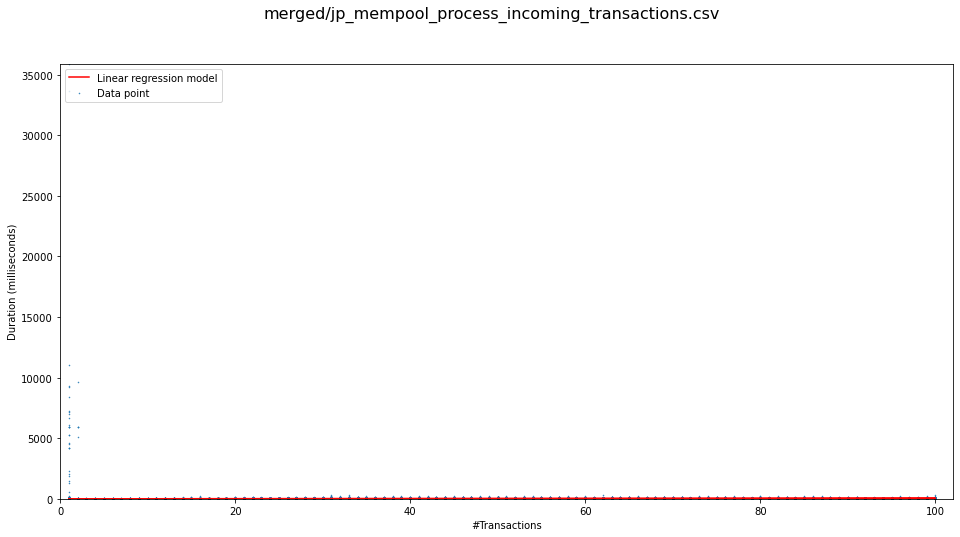

In [12]:
#Perform linear regression with R-sqaured score with pyplot before data cleanup
model_nr = 1

X = data_frames[model_nr].iloc[:, 0].values.reshape(-1, 1)
Y = data_frames[model_nr].iloc[:, 1].values.reshape(-1, 1)
print("Plot before data cleaning:")

plot_regression(X, Y, files[model_nr])

In [13]:
#Data cleanup
data_cleaned = pd.DataFrame(columns = ["txns", "duration"])

data = data_frames[model_nr][data_frames[model_nr]['txns'] > 0].reset_index(drop=True)

data = data.groupby('txns').filter(lambda x: len(x) > 10)

#data = data[data['txns'].between(data['txns'].quantile(0), data['txns'].quantile(.95))]

i = 1
while i <= max(data['txns']):
    temp_data = data[data['txns'] == i]
    if len(temp_data) < 1:
        i+=1
        continue;
        
    temp_data = temp_data[temp_data['duration'] <= 2*temp_data['duration'].std() + temp_data['duration'].mean()]
    data_cleaned = data_cleaned.append(temp_data)
    i+=1
    
#data_cleaned = data_frames[model_nr]

Plot after data cleaning:


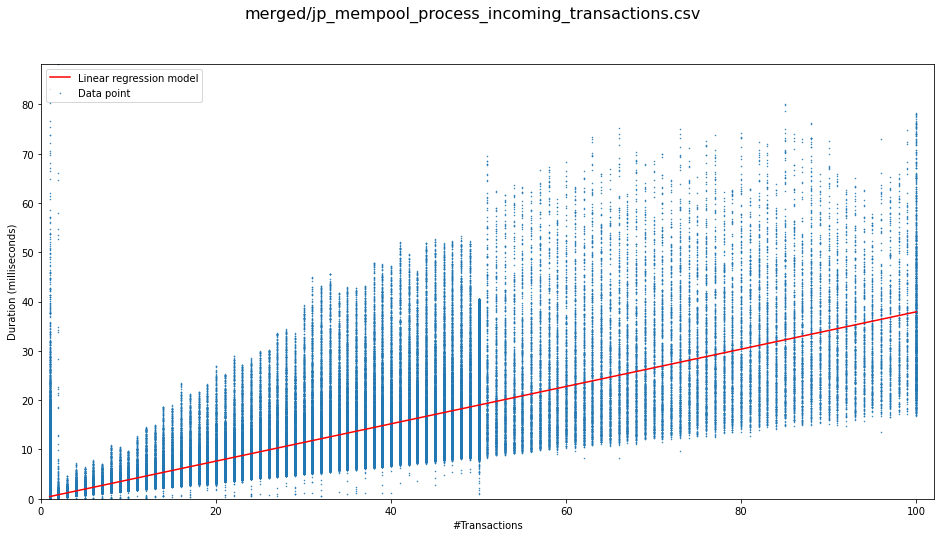

In [14]:
#Perform linear regression with R-sqaured score with pyplot after data cleanup
X = data_cleaned.iloc[:, 0].values.reshape(-1, 1)
Y = data_cleaned.iloc[:, 1].values.reshape(-1, 1)
print("Plot after data cleaning:")

plot_regression(X, Y, files[model_nr]) 

/home/jeanpierre/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Data points: 560
2.0624763368728116 8.168813320250042 8.1280506836926
alpha: KstestResult(statistic=0.047612425803977676, pvalue=0.15284981962824817)
Other: KstestResult(statistic=0.04725858067883365, pvalue=0.1587387351360745)


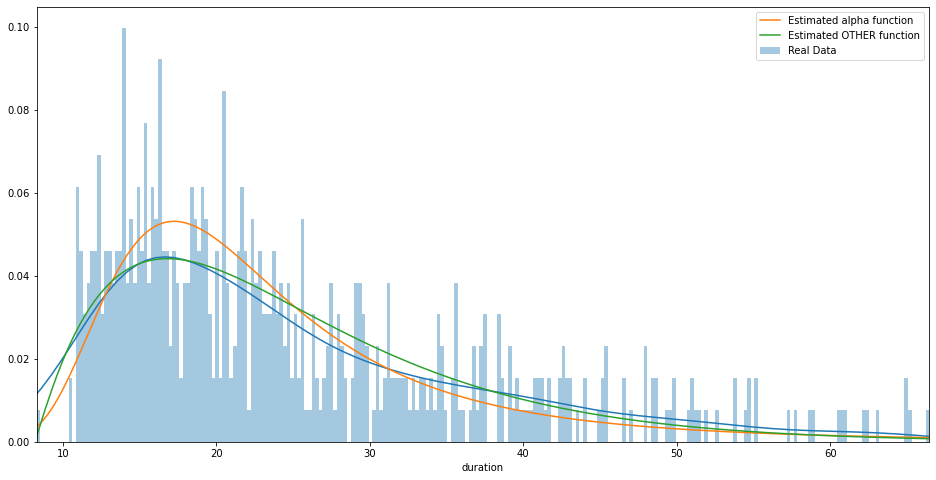

In [15]:
fig, ax = plt.subplots(figsize=(16,8))

data = data_cleaned[data_cleaned['txns'] == 62]['duration']

sns.distplot(data, ax=ax, label="Real Data", bins=250)

#Fitting the gamma distribution
x_min = min(data)
x_max = max(data)
X = np.linspace(x_min, x_max, 300)

fit_a_alpha, fit_loc_alpha, fit_scale_alpha = stats.alpha.fit(data)
fit_a, fit_loc, fit_scale = stats.gamma.fit(data)

alpha_fit = stats.alpha(fit_a_alpha, loc=fit_loc_alpha, scale=fit_scale_alpha)
gamma_fit = stats.gamma(fit_a, loc=fit_loc, scale=fit_scale)

#gamma_manual = stats.gamma(a=1.4, loc=0, scale=1.1)
ax.plot(X, alpha_fit.pdf(X), label="Estimated alpha function")
ax.plot(X, gamma_fit.pdf(X), label="Estimated OTHER function")
#ax.plot(X, gamma_manual.pdf(X), label="Manual gamma function")
ax.set_xlim(x_min, x_max)
ax.legend()
print("Data points:", len(data))
print(fit_a, fit_loc, fit_scale)

p_alpha_fit = stats.kstest(data, alpha_fit.cdf)
p_fit = stats.kstest(data, gamma_fit.cdf)
#p_manual = stats.kstest(data, gamma_manual.cdf)
print("alpha:", p_alpha_fit)
print("Other:", p_fit)
#print(p_manual)

Text(0.3, 0.9, '$Avg-P-value(model)=0.018$')

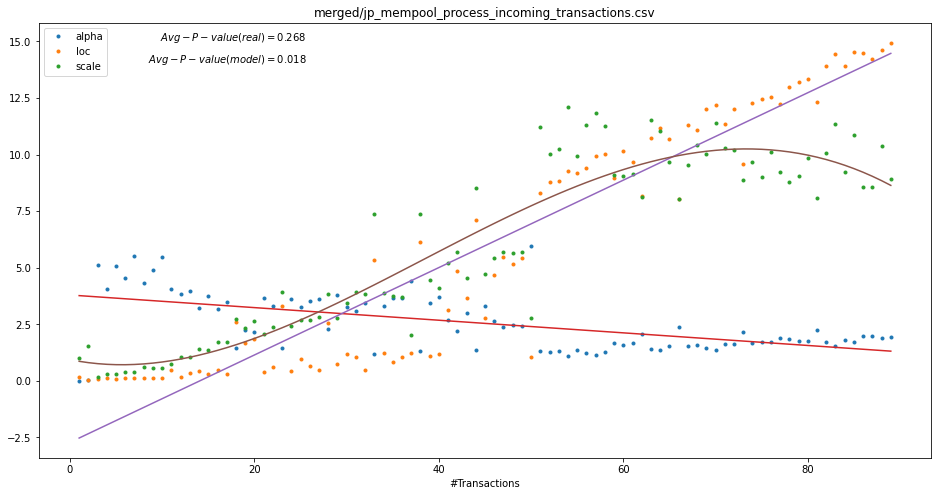

In [16]:
model_nr = 1

#Fit and print the Gamma distribution parameters
temp_fit_alpha = []
temp_fit_loc = []
temp_fit_scale = []
temp_p_fit_real = []
X = []

i = 1
max_txns = max(data_cleaned['txns'])
while i < max_txns - 10:
    data = data_cleaned[data_cleaned['txns'] == i]['duration']
    if len(data) < 1:
        i += 1
        continue
    fit_alpha, fit_loc, fit_scale = stats.gamma.fit(data)
    temp_fit_alpha.append(fit_alpha)
    temp_fit_loc.append(fit_loc)
    temp_fit_scale.append(fit_scale)
    
    p_fit = stats.kstest(data, stats.gamma(fit_alpha, loc=fit_loc, scale=fit_scale).cdf)
    temp_p_fit_real.append(p_fit[1])
    X.append(i)
    i += 1

X = np.array(X).reshape(-1,1)

fig, ax = plt.subplots(figsize=(16,8))
ax.set_title(files[model_nr])
ax.set_xlabel('#Transactions')
#ax.set_ylim(-250, 250)

ax.plot(X, temp_fit_alpha, label='alpha', marker='.', linestyle='None')
ax.plot(X, temp_fit_loc, label='loc', marker='.', linestyle='None')
ax.plot(X, temp_fit_scale, label='scale', marker='.', linestyle='None')
ax.legend(loc='upper left')

#Model the three gamma parameters into a polynomial fit
#weights = np.ones_like(temp_fit_alpha)
#weights[0] = 1000
coefficients_alpha = np.polyfit(X.flatten(), temp_fit_alpha, 1)
poly_alpha = np.poly1d(coefficients_alpha)
new_y = poly_alpha(X.flatten())
ax.plot(X.flatten(), new_y)

coefficients_loc = np.polyfit(X.flatten(), temp_fit_loc, 1)
poly_loc = np.poly1d(coefficients_loc)
new_y = poly_loc(X.flatten())
ax.plot(X.flatten(), new_y)

coefficients_scale = np.polyfit(X.flatten(), temp_fit_scale, 4)
poly_scale = np.poly1d(coefficients_scale)
new_y = poly_scale(X.flatten())
ax.plot(X.flatten(), new_y)

coefficients_models.append([coefficients_alpha, coefficients_loc, coefficients_scale])

#Calculate the p-values for the linear fit models
temp_p_fit_model = []
i = 1
while i < len(X):
    data = data_cleaned[data_cleaned['txns'] == i]['duration']
    if len(data) <= 1:
        i += 1
        continue
    
    a_pred = poly_alpha(i)
    loc_pred = poly_loc(i)
    scale_pred = poly_scale(i)
    
    p_fit = stats.kstest(data, stats.gamma(a_pred, loc=loc_pred, scale=scale_pred).cdf)
    temp_p_fit_model.append(p_fit[1])
    i += 1

#print(temp_p_fit_real)
#print(temp_p_fit_model)
ax.text(0.3, 0.95, "$Avg-P-value(real)={:.3f}$".format(stats.describe(temp_p_fit_real)[2]), verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
ax.text(0.3, 0.9, "$Avg-P-value(model)={:.3f}$".format(stats.describe(temp_p_fit_model)[2]), verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)


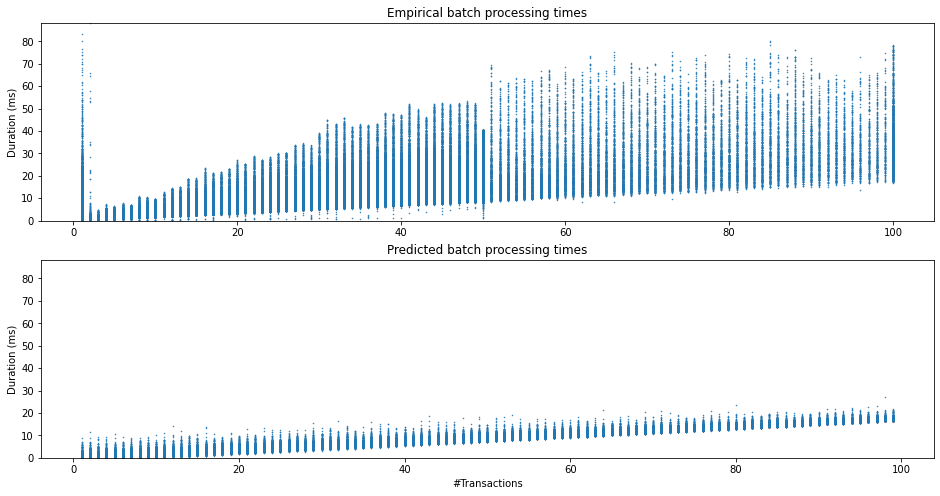

In [17]:
#Create and plot both the empirical/estimated batch processing times
X_data = []
Y_data = []

i = 1
while i < max(data_cleaned['txns']):
    nr_txns = [[i]]
    a_pred = poly_alpha(i)
    loc_pred = poly_loc(i)
    scale_pred = 1

    rvs = stats.gamma.rvs(a=a_pred, loc=loc_pred, scale=scale_pred, size=300)
    X_data.extend([i] * len(rvs))
    Y_data.extend(rvs)
    i += 1
  
fig, ax = plt.subplots(2, 1, figsize=(16,8))
ax[0].set_title("Empirical batch processing times")
ax[0].set_ylabel('Duration (ms)')
ax[0].scatter(data_cleaned['txns'], data_cleaned['duration'], marker='.', s=1, label='Data point');

ax[1].set_title("Predicted batch processing times")
ax[1].set_xlabel('#Transactions')
ax[1].set_ylabel('Duration (ms)')
ax[1].scatter(X_data, Y_data, marker='.', s=1, label='Data point');

max_y = max(max(data_cleaned['duration']), max(Y_data))
ax[0].set_ylim(0, max_y)
ax[1].set_ylim(0, max_y);

Plot before data cleaning:


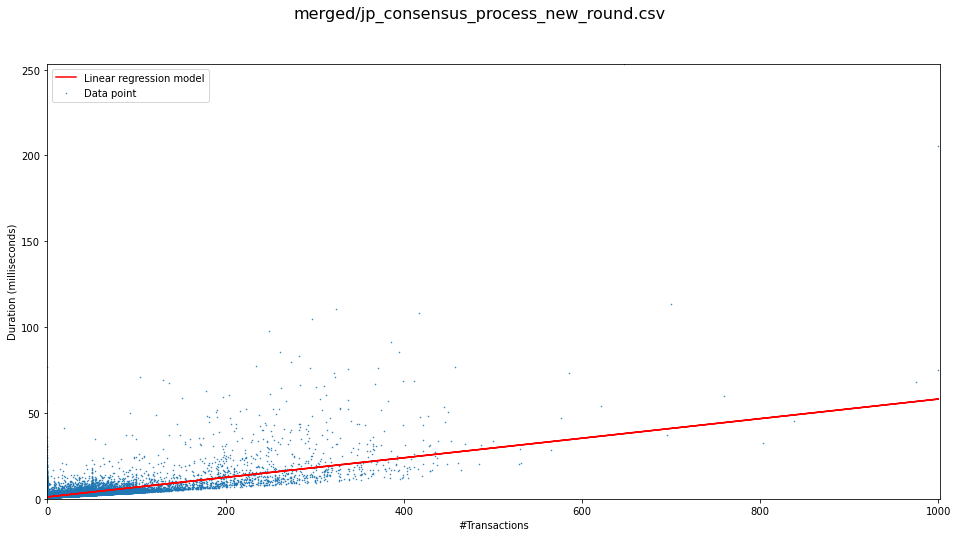

In [18]:
#Perform linear regression with R-sqaured score with pyplot before data cleanup
model_nr = 2

X = data_frames[model_nr].iloc[:, 0].values.reshape(-1, 1)
Y = data_frames[model_nr].iloc[:, 1].values.reshape(-1, 1)
print("Plot before data cleaning:")

plot_regression(X, Y, files[model_nr])

In [19]:
#Data cleanup
data_cleaned = pd.DataFrame(columns = ["txns", "duration"])

data = data_frames[model_nr][data_frames[model_nr]['txns'] > 0].reset_index(drop=True)

data = data.groupby('txns').filter(lambda x: len(x) > 10)

#data = data[data['txns'].between(data['txns'].quantile(0), data['txns'].quantile(.95))]

i = 1
while i <= max(data['txns']):
    temp_data = data[data['txns'] == i]
    if len(temp_data) < 1:
        i+=1
        continue;
        
    temp_data = temp_data[temp_data['duration'] <= 2*temp_data['duration'].std() + temp_data['duration'].mean()]
    data_cleaned = data_cleaned.append(temp_data)
    i+=1
    
#data_cleaned = data_frames[model_nr]

Plot after data cleaning:


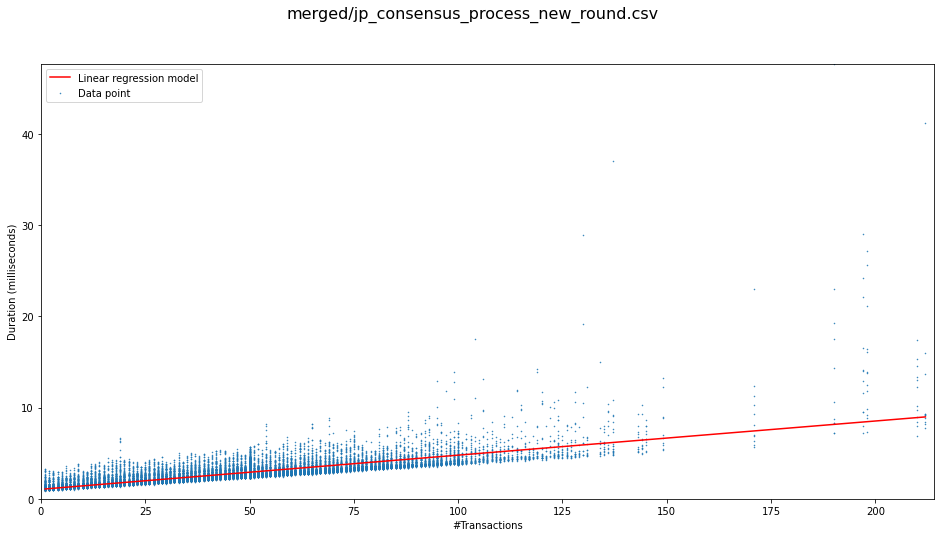

In [20]:
#Perform linear regression with R-sqaured score with pyplot after data cleanup
X = data_cleaned.iloc[:, 0].values.reshape(-1, 1)
Y = data_cleaned.iloc[:, 1].values.reshape(-1, 1)
print("Plot after data cleaning:")

plot_regression(X, Y, files[model_nr]) 

/home/jeanpierre/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/jeanpierre/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jeanpierre/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


ValueError: min() arg is an empty sequence

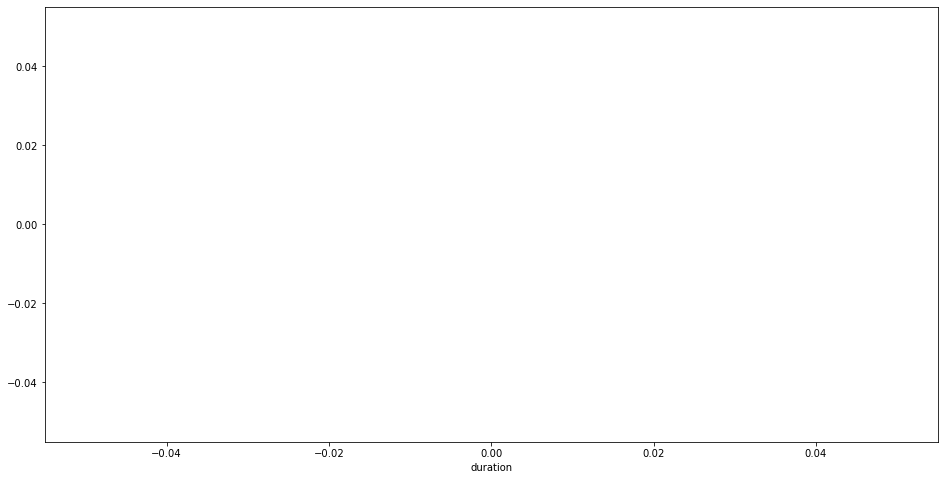

In [21]:
fig, ax = plt.subplots(figsize=(16,8))

data = data_cleaned[data_cleaned['txns'] == 1000]['duration']

sns.distplot(data, ax=ax, label="Real Data", bins=250)

#Fitting the gamma distribution
x_min = min(data)
x_max = max(data)
X = np.linspace(x_min, x_max, 300)

fit_a_alpha, fit_loc_alpha, fit_scale_alpha = stats.alpha.fit(data)
fit_a, fit_loc, fit_scale = stats.gamma.fit(data)

alpha_fit = stats.alpha(fit_a_alpha, loc=fit_loc_alpha, scale=fit_scale_alpha)
gamma_fit = stats.gamma(fit_a, loc=fit_loc, scale=fit_scale)


ax.plot(X, alpha_fit.pdf(X), label="Estimated alpha function")
ax.plot(X, gamma_fit.pdf(X), label="Estimated OTHER function")

ax.set_xlim(x_min, x_max)
ax.legend()
print("Data points:", len(data))
print(fit_a, fit_loc, fit_scale)

p_alpha_fit = stats.kstest(data, alpha_fit.cdf)
p_fit = stats.kstest(data, gamma_fit.cdf)

print("alpha:", p_alpha_fit)
print("Other:", p_fit)
#print(p_manual)

Text(0.3, 0.9, '$Avg-P-value(model)=nan$')

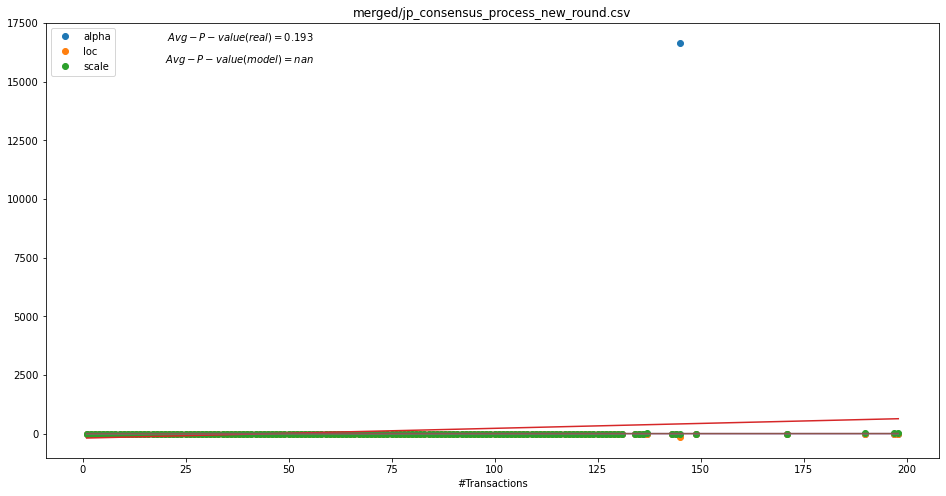

In [22]:
model_nr = 2

#Fit and print the Gamma distribution parameters
temp_fit_alpha = []
temp_fit_loc = []
temp_fit_scale = []
temp_p_fit_real = []
X = []

i = 1
max_txns = max(data_cleaned['txns'])
while i < max_txns - 10:
    data = data_cleaned[data_cleaned['txns'] == i]['duration']
    if len(data) < 1:
        i += 1
        continue
    fit_alpha, fit_loc, fit_scale = stats.gamma.fit(data)
    temp_fit_alpha.append(fit_alpha)
    temp_fit_loc.append(fit_loc)
    temp_fit_scale.append(fit_scale)
    
    p_fit = stats.kstest(data, stats.gamma(fit_alpha, loc=fit_loc, scale=fit_scale).cdf)
    temp_p_fit_real.append(p_fit[1])
    X.append(i)
    i += 1

X = np.array(X).reshape(-1,1)

fig, ax = plt.subplots(figsize=(16,8))
ax.set_title(files[model_nr])
ax.set_xlabel('#Transactions')
#ax.set_ylim(-250, 250)

ax.plot(X, temp_fit_alpha, label='alpha', marker='o', linestyle='None')
ax.plot(X, temp_fit_loc, label='loc', marker='o', linestyle='None')
ax.plot(X, temp_fit_scale, label='scale', marker='o', linestyle='None')
ax.legend(loc='upper left')

#Model the three gamma parameters into a polynomial fit
#weights = np.ones_like(temp_fit_alpha)
#weights[0] = 1000
coefficients_alpha = np.polyfit(X.flatten(), temp_fit_alpha, 1)
poly_alpha = np.poly1d(coefficients_alpha)
new_y = poly_alpha(X.flatten())
ax.plot(X.flatten(), new_y)

coefficients_loc = np.polyfit(X.flatten(), temp_fit_loc, 1)
poly_loc = np.poly1d(coefficients_loc)
new_y = poly_loc(X.flatten())
ax.plot(X.flatten(), new_y)

coefficients_scale = np.polyfit(X.flatten(), temp_fit_scale, 1)
poly_scale = np.poly1d(coefficients_scale)
new_y = poly_scale(X.flatten())
ax.plot(X.flatten(), new_y)

coefficients_models.append([coefficients_alpha, coefficients_loc, coefficients_scale])

#Calculate the p-values for the linear fit models
temp_p_fit_model = []
i = 1
while i < len(X):
    data = data_cleaned[data_cleaned['txns'] == i]['duration']
    if len(data) <= 1:
        i += 1
        continue
    
    a_pred = poly_alpha(i)
    loc_pred = poly_loc(i)
    scale_pred = poly_scale(i)
    
    p_fit = stats.kstest(data, stats.gamma(a_pred, loc=loc_pred, scale=scale_pred).cdf)
    temp_p_fit_model.append(p_fit[1])
    i += 1

#print(temp_p_fit_real)
#print(temp_p_fit_model)
ax.text(0.3, 0.95, "$Avg-P-value(real)={:.3f}$".format(stats.describe(temp_p_fit_real)[2]), verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
ax.text(0.3, 0.9, "$Avg-P-value(model)={:.3f}$".format(stats.describe(temp_p_fit_model)[2]), verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)


In [23]:
#Create and plot both the empirical/estimated batch processing times
X_data = []
Y_data = []

i = 1
while i < max(data_cleaned['txns']):
    nr_txns = [[i]]
    a_pred = poly_alpha(i)
    loc_pred = poly_loc(i)
    scale_pred = poly_scale(i)

    rvs = stats.gamma.rvs(a=a_pred, loc=loc_pred, scale=scale_pred, size=300)
    X_data.extend([i] * len(rvs))
    Y_data.extend(rvs)
    i += 1
  
fig, ax = plt.subplots(2, 1, figsize=(16,8))
ax[0].set_title("Empirical batch processing times")
ax[0].set_ylabel('Duration (ms)')
ax[0].scatter(data_cleaned['txns'], data_cleaned['duration'], marker='.', s=1, label='Data point');

ax[1].set_title("Predicted batch processing times")
ax[1].set_xlabel('#Transactions')
ax[1].set_ylabel('Duration (ms)')
ax[1].scatter(X_data, Y_data, marker='.', s=1, label='Data point');

max_y = max(max(data_cleaned['duration']), max(Y_data))
ax[0].set_ylim(0, max_y)
ax[1].set_ylim(0, max_y);

ValueError: Domain error in arguments.

In [ ]:
#Print the model parameters for export
coefficients_models

In [ ]:
c_1_a = 'c_1_a ='
c_1_l = 'c_1_l ='
c_1_s = 'c_1_s ='

c_2_a = 'c_2_a ='
c_2_l = 'c_2_l ='
c_2_s = 'c_2_s ='

c_3_a = 'c_3_a ='
c_3_l = 'c_3_l ='
c_3_s = 'c_3_s ='
    
for model in range(0, len(coefficients_models)):
    for param in range(0, len(coefficients_models[model])):
        for exponent in range(0, len(coefficients_models[model][param])):
            if model == 0: 
                if param == 0:
                    c_1_a += ' ' + str(coefficients_models[model][param][exponent])
                if param == 1:
                    c_1_l += ' ' + str(coefficients_models[model][param][exponent])
                if param == 2:
                    c_1_s += ' ' + str(coefficients_models[model][param][exponent])
                
            if model == 1: 
                if param == 0:
                    c_2_a += ' ' + str(coefficients_models[model][param][exponent])
                if param == 1:
                    c_2_l += ' ' + str(coefficients_models[model][param][exponent])
                if param == 2:
                    c_2_s += ' ' + str(coefficients_models[model][param][exponent])
                
            if model == 2: 
                if param == 0:
                    c_3_a += ' ' + str(coefficients_models[model][param][exponent])
                if param == 1:
                    c_3_l += ' ' + str(coefficients_models[model][param][exponent])
                if param == 2:
                    c_3_s += ' ' + str(coefficients_models[model][param][exponent])
                
                
print(c_1_a)
print(c_1_l)
print(c_1_s)
print()
print(c_2_a)
print(c_2_l)
print(c_2_s)
print()
print(c_3_a)
print(c_3_l)
print(c_3_s)